# Hazem Zaky
# Programming Exercise \#3
---

# Preamble

In [28]:
# optional code cell when using Google Colab with Google Drive

# remove the docstring comment block below in order to mount Google Drive
'''
# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
### %cd /content/drive/My\ Drive/[MY PATH] ###
'''

"\n# mount Google Drive in Google Colab\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n# change directory using the magic command %cd\n### replace [MY PATH] below with your own path in Google Drive ###\n### %cd /content/drive/My\\ Drive/[MY PATH] ###\n"

In [29]:
# import relevant Python libraries

import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

# **1. Noise Level Classification Using Plug-in Classifiers**

## 1.1

### (a)

In [30]:
### Your code for 1.1(a) goes here ###
noise_training = pd.read_csv('data/NoiseClassificationTrainingData.csv', engine="python") 
class_0 = noise_training[noise_training["ClassLabel"] == 0]["NoiseLevel"]
class_1 = noise_training[noise_training["ClassLabel"] == 1]["NoiseLevel"]
class_2 = noise_training[noise_training["ClassLabel"] == 2]["NoiseLevel"]
mean_0 = np.mean(class_0)
mean_1 = np.mean(class_1)
mean_2 = np.mean(class_2)

centered_data = np.concatenate([class_0 - mean_0, class_1 - mean_1, class_2 - mean_2])
common_variance = np.var(centered_data, ddof = 0)
print(f"Class 0 Mean: {mean_0}")
print(f"Class 1 Mean: {mean_1}")
print(f"Class 2 Mean: {mean_2}")
print(f"Variance: {common_variance}")

Class 0 Mean: 44.65630954576823
Class 1 Mean: 55.277231807111434
Class 2 Mean: 64.88690064177815
Variance: 11.995287584605002


### (b)

The parameter that can switch it is ddof. This is the Delta Degrees of Freedom. When it's set to 0 it's a biased estimate. Increasing it makes unbiased.

## 1.2

### (a)

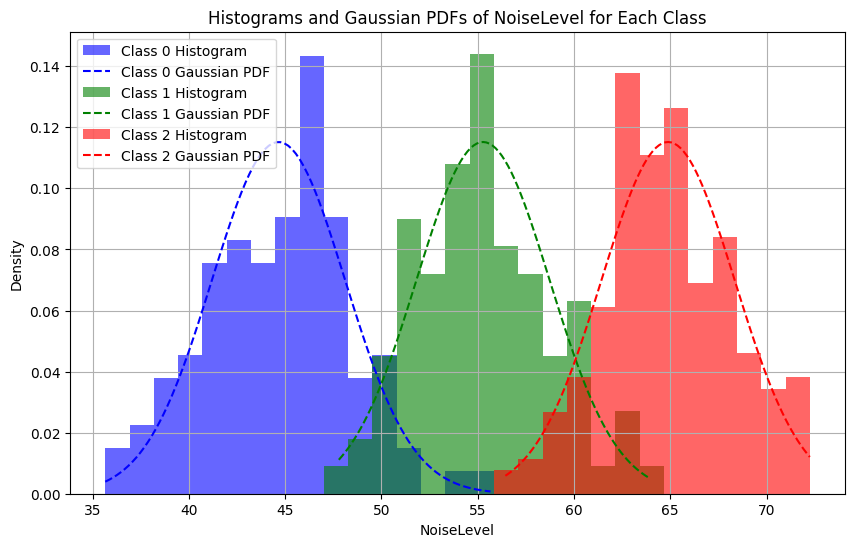

In [31]:
### Your code for 1.2 goes here ###
colors = ['blue', 'green', 'red']

# Create the histogram and overlay PDFs
plt.figure(figsize=(10, 6))
bins = np.linspace(noise_training["NoiseLevel"].min(), noise_training["NoiseLevel"].max(), 30)  # Set number of bins for the histogram

# Plot histogram and PDF for each class
for i, (class_data, mean, color, label) in enumerate(zip(
    [class_0, class_1, class_2], [mean_0, mean_1, mean_2], colors, ["Class 0", "Class 1", "Class 2"]
)):
    # Plot histogram
    plt.hist(class_data, bins=bins, density=True, alpha=0.6, color=color, label=f'{label} Histogram')
    
    # Calculate the Gaussian PDF
    x = np.linspace(min(class_data), max(class_data), 100)
    pdf = sps.norm.pdf(x, mean, np.sqrt(common_variance))
    
    # Plot PDF
    plt.plot(x, pdf, color=color, linestyle='--', label=f'{label} Gaussian PDF')

# Add labels, title, and legend
plt.xlabel('NoiseLevel')
plt.ylabel('Density')
plt.title('Histograms and Gaussian PDFs of NoiseLevel for Each Class')
plt.legend()
plt.grid(True)
plt.show()


### (b)

The gaussian distribution with shared variance but different means is a reasonable assumption because the histograms have a relatively similar shape and peaks as the gaussian PDFs so the estimated likelihood functions are valid.

## 1.3

In [32]:
### Your code for 1.3 goes here ###
prior_0 = class_0.size/noise_training.shape[0]
prior_1 = class_1.size/noise_training.shape[0]
prior_2 = class_2.size/noise_training.shape[0]
print(f"Class 0 Prior: {prior_0}")
print(f"Class 1 Prior: {prior_1}")
print(f"Class 2 Prior: {prior_2}")

Class 0 Prior: 0.2625
Class 1 Prior: 0.22
Class 2 Prior: 0.5175


## 1.4

In [33]:
### Your code for 1.4 goes here ###
noise_test = pd.read_csv('data/NoiseClassificationTestData.csv', engine="python")
loss_matrix = np.array([[-1, 2, 4],
                        [2, 0, 4],
                        [4, 4, 0]])
def classifier(classifier_type, noise_level, means=[mean_0, mean_1, mean_2], common_variance=common_variance, priors=[prior_0, prior_1, prior_2], loss_matrix = loss_matrix):
    def mle(noise_level, means, common_variance):
        likelihoods = [sps.norm.pdf(noise_level, mean, np.sqrt(common_variance)) for mean in means]
        return np.argmax(likelihoods)
    def map(noise_level, means, common_variance, priors):
        probabilities = np.array([sps.norm.pdf(noise_level, mean, np.sqrt(common_variance)) * prior for mean, prior in zip(means, priors)])
        return np.argmax(probabilities)
    
    def general_bayes(noise_level, means, common_variance, priors, loss_matrix):
        probabilities = np.array([sps.norm.pdf(noise_level, mean, np.sqrt(common_variance)) * prior for mean, prior in zip(means, priors)])
        return np.argmin(np.dot(loss_matrix, probabilities))
    
    if classifier_type == "mle":
        return mle(noise_level, means, common_variance)
    elif classifier_type == "map":
        return map(noise_level, means, common_variance, priors)
    if classifier_type == "general_bayes":
        return general_bayes(noise_level, means, common_variance, priors, loss_matrix)

noise_test["MLE"] = noise_test["NoiseLevel"].apply(
    lambda x: classifier("mle", x)
)
noise_test["MAP"] = noise_test["NoiseLevel"].apply(
    lambda x: classifier("map", x)
)
noise_test["General_Bayes"] = noise_test["NoiseLevel"].apply(
    lambda x: classifier("general_bayes", x)
)


## 1.5

### (a)

In [34]:
### Your code for 1.5(a) goes here ###
def calculate_empirical_risk(true_labels, predicted_labels):
    n_samples = len(true_labels)
    # Count the number of incorrect predictions
    incorrect_predictions = sum(true_label != predicted_label for true_label, predicted_label in zip(true_labels, predicted_labels))
    
    # Calculate empirical risk as the fraction of incorrect predictions
    empirical_risk = incorrect_predictions / n_samples
    
    # Count the number of samples identified as each class
    unique_classes, predicted_counts = np.unique(predicted_labels, return_counts=True)
    identified_counts = dict(zip(unique_classes, predicted_counts))
    
    # Count correct predictions by class, ensuring integer keys
    correct_by_class = {}
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        if true_label == predicted_label:
            true_label_int = int(true_label)  # Ensure the key is an integer
            if true_label_int in correct_by_class:
                correct_by_class[true_label_int] += 1
            else:
                correct_by_class[true_label_int] = 1
    
    # Sort the dictionary by keys
    correct_by_class = dict(sorted(correct_by_class.items()))
    
    return empirical_risk, correct_by_class, identified_counts

# Extract true labels
true_labels = noise_test['ClassLabel'].to_numpy()

# Calculate empirical risk for each classifier with 0/1 loss and display additional metrics
empirical_risk_mle_0_1, correct_by_class_mle, identified_counts_mle = calculate_empirical_risk(true_labels, noise_test['MLE'].to_numpy())
empirical_risk_map_0_1, correct_by_class_map, identified_counts_map = calculate_empirical_risk(true_labels, noise_test['MAP'].to_numpy())
empirical_risk_general_bayes_0_1, correct_by_class_general_bayes, identified_counts_general_bayes = calculate_empirical_risk(true_labels, noise_test['General_Bayes'].to_numpy())

# Print results for each classifier
print(f"MLE 0/1 Loss: {empirical_risk_mle_0_1:.2f}")
print(f"Samples identified as each class by MLE: {identified_counts_mle}")
print(f"Samples correctly identified by MLE by class: {correct_by_class_mle}\n")

print(f"MAP 0/1 Loss: {empirical_risk_map_0_1:.2f}")
print(f"Samples identified as each class by MAP: {identified_counts_map}")
print(f"Samples correctly identified by MAP by class: {correct_by_class_map}\n")

print(f"General Bayes 0/1 Loss: {empirical_risk_general_bayes_0_1:.2f}")
print(f"Samples identified as each class by General Bayes: {identified_counts_general_bayes}")
print(f"Samples correctly identified by General Bayes by class: {correct_by_class_general_bayes}")


MLE 0/1 Loss: 0.08
Samples identified as each class by MLE: {0: 22, 1: 28, 2: 50}
Samples correctly identified by MLE by class: {0: 21, 1: 21, 2: 50}

MAP 0/1 Loss: 0.07
Samples identified as each class by MAP: {0: 23, 1: 25, 2: 52}
Samples correctly identified by MAP by class: {0: 22, 1: 20, 2: 51}

General Bayes 0/1 Loss: 0.04
Samples identified as each class by General Bayes: {0: 26, 1: 22, 2: 52}
Samples correctly identified by General Bayes by class: {0: 25, 1: 20, 2: 51}


### (b)

In [35]:
### Your code for 1.5(b) goes here ###
def calculate_empirical_risk_matrix(true_labels, predicted_labels, loss_matrix):
    total_loss = 0
    n_samples = len(true_labels)
    true_labels = true_labels.astype(int)
    predicted_labels = predicted_labels.astype(int)
    
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        total_loss += loss_matrix[true_label, predicted_label]
    
    empirical_risk = total_loss / n_samples
    return empirical_risk



# Extract true labels
true_labels = noise_test['ClassLabel'].to_numpy()

# Calculate empirical risk for each classifier
empirical_risk_mle = calculate_empirical_risk_matrix(true_labels, noise_test['MLE'].to_numpy(), loss_matrix)
empirical_risk_map = calculate_empirical_risk_matrix(true_labels, noise_test['MAP'].to_numpy(), loss_matrix)
empirical_risk_general_bayes = calculate_empirical_risk_matrix(true_labels, noise_test['General_Bayes'].to_numpy(), loss_matrix)

print(f"MLE Loss: {empirical_risk_mle:.2f}")
print(f"MAP Loss: {empirical_risk_map:.2f}")
print(f"General Bayes Loss: {empirical_risk_general_bayes:.2f}")

MLE Loss: -0.03
MAP Loss: -0.06
General Bayes Loss: -0.15


## 1.6

### (a)

MAP because it always aims to minimze zero-one loss

### (b)

General Bayes since it is the only classifier that takes into account the loss matrix

### (c)

No, MAP doesn't align with the 0-1 loss, but General Bayes aligns with the loss matrix calculations

### (d)

It's possible that there simply was not enough data for the MAP classifier to be completely accurate. As we increase the sample size of each of the 3 classes, we should see that the MAP classifier does indeed minimize the 0/1 loss.